## Test out UGRID-0.9 compliant unstructured grid model datasets with PYUGRID

In [1]:
%matplotlib inline

In [2]:
import numpy as np
import matplotlib.tri as tri
import matplotlib.pyplot as plt
import datetime as dt
import netCDF4

In [3]:
import cartopy.crs as ccrs
from cartopy.io.img_tiles import MapQuestOpenAerial, MapQuestOSM, OSM

In [4]:
import iris
import pyugrid

In [5]:
iris.FUTURE.netcdf_promote = True

In [6]:
#ADCIRC
#url =  'http://comt.sura.org/thredds/dodsC/data/comt_1_archive/inundation_tropical/UND_ADCIRC/Hurricane_Ike_3D_final_run_with_waves'
#FVCOM
#url = 'http://www.smast.umassd.edu:8080/thredds/dodsC/FVCOM/NECOFS/Forecasts/NECOFS_GOM3_FORECAST.nc'
#SELFE
#url = 'http://comt.sura.org/thredds/dodsC/data/comt_1_archive/inundation_tropical/VIMS_SELFE/Hurricane_Ike_2D_final_run_with_waves'

In [7]:
# UMASSD/SMAST FVCOM Simulations in support of Water Quality for MWRA
url = 'http://www.smast.umassd.edu:8080/thredds/dodsC/fvcom/mwra/fvcom'
var = 'sea_water_salinity'    # use standard_name if it exists
levs = np.arange(28.,33.5,.1)   # contour levels for plotting
klev = 0   # level 0 is top in FVCOM

In [8]:
# UMASSD/SMAST Water Quality FVCOM Simulation for MWRA
url = 'http://www.smast.umassd.edu:8080/thredds/dodsC/fvcom/mwra/wq'
var = 'Dissolved oxygen'  # use long_name because DO has no standard_name in this dataset
levs = np.arange(5.,15.,.25)   # contour levels for plotting
klev = 0   # level 0 is top in FVCOM

In [9]:
# Desired time for snapshot
# ....right now (or some number of hours from now) ...
start = dt.datetime.utcnow() + dt.timedelta(hours=6)
# ... or specific time (UTC)
start = dt.datetime(1998,3,2,15,0,0)

In [10]:
nc = netCDF4.Dataset(url)
#print nc.variables.keys()  # list variables
#nc.variables['DO']  # show variable with attributes

In [11]:
cube = iris.load_cube(url,var)    # Iris uses the standard_name or long_name to access variables

/home/usgs/miniconda/envs/ioos/lib/python2.7/site-packages/iris/fileformats/_pyke_rules/compiled_krb/fc_rules_cf_fc.py:1300: UserWarning: Ignoring netCDF variable u'Itime2' invalid units u'msec since 00:00:00'
  warnings.warn(msg.encode('ascii', errors='backslashreplace'))
/home/usgs/miniconda/envs/ioos/lib/python2.7/site-packages/iris/fileformats/_pyke_rules/compiled_krb/fc_rules_cf_fc.py:1300: UserWarning: Ignoring netCDF variable u'TPSI' invalid units u'mg Si/l'
  warnings.warn(msg.encode('ascii', errors='backslashreplace'))
/home/usgs/miniconda/envs/ioos/lib/python2.7/site-packages/iris/fileformats/_pyke_rules/compiled_krb/fc_rules_cf_fc.py:1300: UserWarning: Ignoring netCDF variable u'DOP' invalid units u'mg P/l'
  warnings.warn(msg.encode('ascii', errors='backslashreplace'))
/home/usgs/miniconda/envs/ioos/lib/python2.7/site-packages/iris/fileformats/_pyke_rules/compiled_krb/fc_rules_cf_fc.py:1300: UserWarning: Ignoring netCDF variable u'POP' invalid units u'mg P/l'
  warnings.war

In [12]:
# Get desired time step  
time_var = nc['time']
itime = netCDF4.date2index(start,time_var,select='nearest')

In [13]:
ug = pyugrid.UGrid.from_ncfile(url)

print "There are %i nodes"%ug.nodes.shape[0]
print "There are %i faces"%ug.faces.shape[0]

There are 4537 nodes
There are 8096 faces


In [14]:
print cube

Dissolved oxygen / (mg/l)           (time: 2440; -- : 30; -- : 4537)
     Dimension coordinates:
          time                           x          -        -
     Auxiliary coordinates:
          sea_surface_height_above_geoid x          -        x
          Sigma Layers                   -          x        x
          latitude                       -          -        x
          longitude                      -          -        x
          sea_floor_depth_below_geoid    -          -        x
     Attributes:
          Conventions: CF-1.0, UGRID-0.9
          CoordinateProjection: init=nad83:1802
          CoordinateSystem: Cartesian
          DODS.dimName: DateStrLen
          DODS.strlen: 26
          cdm_data_type: any
          coverage_content_type: modelResult
          history: convert binary file to NetCDF
          location: node
          mesh: fvcom_mesh
          references: http://fvcom.smast.umassd.edu, http://codfish.smast.umassd.edu
          source: FVCOM_3.0
    

In [15]:
cube.mesh = ug
cube.mesh_dimension = 1  # (0:time,1:node)

In [16]:
lon = cube.mesh.nodes[:,0]
lat = cube.mesh.nodes[:,1]
nv = cube.mesh.faces

In [17]:
triang = tri.Triangulation(lon,lat,triangles=nv)

In [18]:
zcube = cube[itime, klev, :]

In [19]:
print zcube.data.min()
print zcube.data.max()

9.18244
13.3583


try simple plot

<matplotlib.tri.tricontour.TriContourSet instance at 0x7fd8d2a885f0>

/home/usgs/miniconda/envs/ioos/lib/python2.7/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


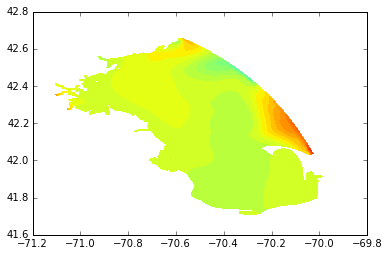

In [20]:
plt.tricontourf(triang, zcube.data, levels=levs)

Try more complex cartopy plot

/home/usgs/miniconda/envs/ioos/lib/python2.7/site-packages/matplotlib/collections.py:650: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors_original != str('face'):


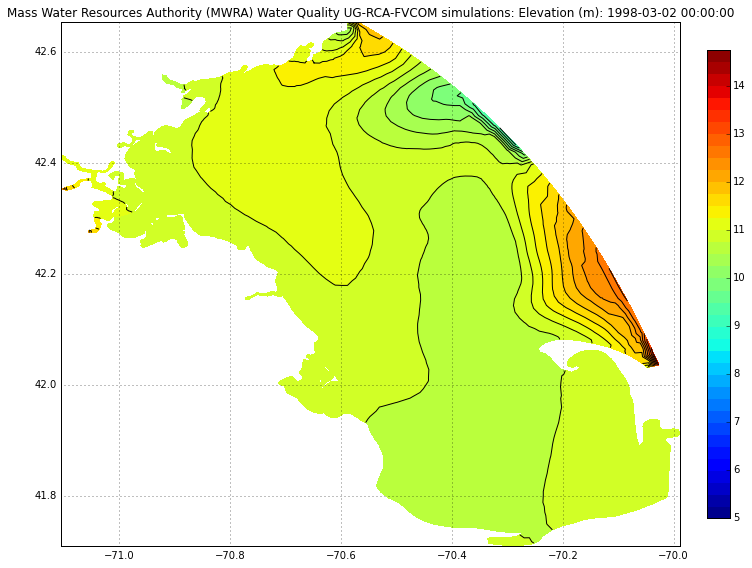

In [21]:
fig = plt.figure(figsize=(12,12))
ax = plt.axes(projection=ccrs.PlateCarree())
#ax.set_extent([-90, -60, 5, 50])
#ax.coastlines('10m')
plt.tricontourf(triang, zcube.data, levels=levs)
plt.colorbar(fraction=0.035, pad=0.04)
plt.tricontour(triang, zcube.data, colors='k',levels=levs)
tvar = cube.coord('time')
tstr = tvar.units.num2date(tvar.points[itime])
gl = ax.gridlines(draw_labels=True)
gl.xlabels_top = False
gl.ylabels_right = False
plt.title('%s: Elevation (m): %s' % (zcube.attributes['title'],tstr));

## Try to plot using tiled background

/home/usgs/miniconda/envs/ioos/lib/python2.7/site-packages/numpy/lib/shape_base.py:431: FutureWarning: in the future np.array_split will retain the shape of arrays with a zero size, instead of replacing them by `array([])`, which always has a shape of (0,).
  FutureWarning)


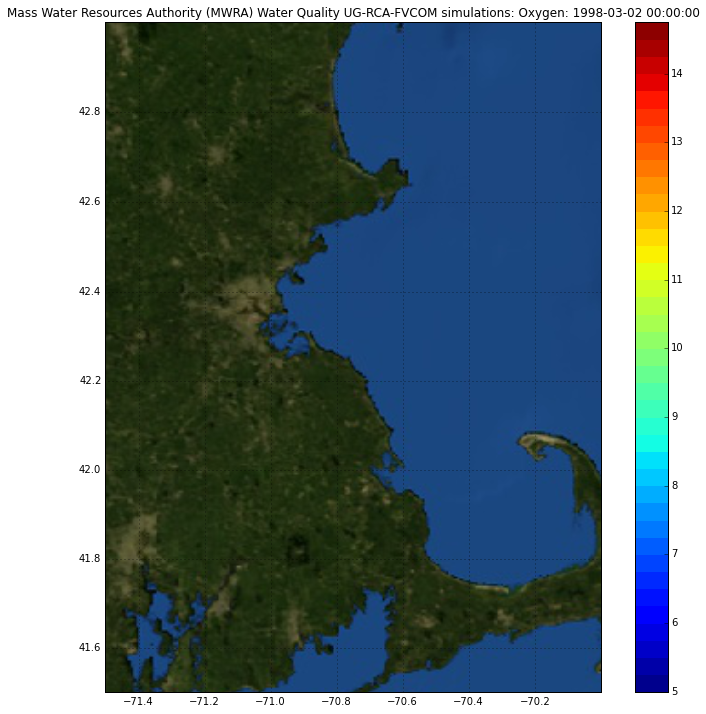

In [22]:
geodetic = ccrs.Geodetic(globe=ccrs.Globe(datum='WGS84'))

fig = plt.figure(figsize=(12,12))
tiler = MapQuestOpenAerial()
ax = plt.axes(projection=tiler.crs)

#ax = plt.axes(projection=ccrs.PlateCarree())
ax.set_extent([-71.5, -70, 41.5, 43],geodetic)
ax.add_image(tiler, 8)

#ax.coastlines()
plt.tricontourf(triang, zcube.data, levels=levs)
plt.colorbar()
plt.tricontour(triang, zcube.data, colors='k',levels=levs)
tvar = cube.coord('time')
tstr = tvar.units.num2date(tvar.points[itime])
gl = ax.gridlines(draw_labels=True)
gl.xlabels_top = False
gl.ylabels_right = False
plt.title('%s: Oxygen: %s' % (zcube.attributes['title'],tstr));